# Libraries

In [ ]:
pip install pytorch_lightning

In [ ]:
!pip install rioxarray

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch.utils.data
import functools as ft
from tqdm import tqdm
from collections import namedtuple
import torch
import torch.nn.functional as F
import torch.optim as optim
import time
import copy
import itertools
import seaborn as sns
import pandas as pd
import rioxarray


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read the data

## original data from Delft3D

In [ ]:
## the unit of the Inorganic Matter (IM) variable is gDM/m3, that means grams of Dry Matter per cubic meter

path_surf = '/content/drive/MyDrive/Material for Master thesis/DATA/IM_surface_regul.nc'
data_surf = xr.open_dataset(path_surf)
data_surf = data_surf.drop_vars(["mesh2d_layer_sigma", "mesh2d_face_x","mesh2d_face_y", "mesh2d_nFaces"])

#extracting the variable
# data_surf = data_surf.rename({'y': 'lat', 'x': 'lon'})
new_value = np.where(data_surf['__xarray_dataarray_variable__'] <= 10**-1, 10**-1, data_surf['__xarray_dataarray_variable__'])  ## removing negative values
new_value = np.where(new_value >= 10**4, 10**4, new_value)                                                                      ## removing high values
# data_surf['SPM'] = (['time', 'lat', 'lon'], new_value) #np.log10(new_value))
data_surf['SPM'] = (['time', 'y', 'x'], np.log10(new_value))                                                                    ## log10 transform

y_test = np.load(r'/content/drive/MyDrive/Material for Master thesis/DATA/y_pred.npy')


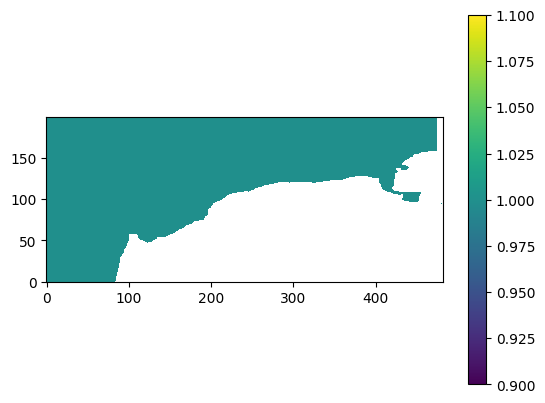

In [ ]:
## creating the land mask (without the islands)
bool_mask = np.isnan(data_surf['SPM'][5,:,:])
mask = np.where(bool_mask == True, np.nan, 1.)
plt.imshow(mask, origin = 'lower')
plt.colorbar()


## Code for masking the islands

In [ ]:
import geopandas
from shapely.geometry import mapping

In [ ]:
data_surf.rio.write_crs("epsg:4326", inplace=True)
islands_shape  = geopandas.read_file('/content/drive/MyDrive/4DVarNet/DFM_data/Wadden_Sea_Islands.shx', crs="epsg:4326")
data_isl_mask = data_surf.rio.clip(islands_shape.geometry.apply(mapping), islands_shape.crs, drop=False, invert=True)

In [ ]:
data_isl_mask

<xarray.Dataset>
Dimensions:                        (time: 732, y: 200, x: 482)
Coordinates:
  * time                           (time) datetime64[ns] 2016-01-01 ... 2018-...
  * y                              (y) float64 52.55 52.56 52.57 ... 53.96 53.97
  * x                              (x) float64 4.004 4.011 4.018 ... 7.424 7.431
    spatial_ref                    int64 0
Data variables:
    __xarray_dataarray_variable__  (time, y, x) float64 13.12 13.84 ... nan nan
    SPM                            (time, y, x) float64 1.118 1.141 ... nan nan

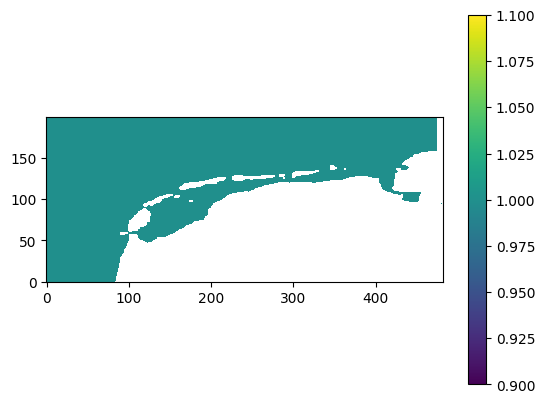

In [ ]:
## creating the land mask (with the islands)
bool_mask = np.isnan(data_isl_mask['SPM'][5,:,:])
mask_new = np.where(bool_mask == True, np.nan, 1.)
plt.imshow(mask_new, origin = 'lower')
plt.colorbar()

## renaming the coordinates fro matching the code

In [ ]:
data_surf      = data_surf.rename({'y': 'lat', 'x': 'lon'})
data_isl_mask = data_isl_mask.rename({'y': 'lat', 'x': 'lon'})

time_ = data_surf['time'].data
lon = data_surf['lon'].data
lat = data_surf['lat'].data

# Pre-processing the data

## script

In [ ]:
TrainingItem = namedtuple('TrainingItem', ['input', 'tgt'])

def compute_rmse(predicted, target, masks):
    valid_mask = masks
    valid_predictions = predicted[valid_mask.bool()]
    valid_targets = target[valid_mask.bool()]
    mse = torch.nanmean((valid_targets - valid_predictions) ** 2)
    return torch.sqrt(mse)

def compute_re(predicted, target, masks):
    valid_mask = masks
    valid_predictions = predicted[valid_mask.bool()]
    valid_targets = target[valid_mask.bool()]
    epsilon = 1e-8  # Small constant to avoid division by zero
    re = torch.nanmean(torch.abs(10**valid_targets - 10**valid_predictions) / (10**valid_targets + epsilon)) * 100
    return re

class XrDataset(torch.utils.data.Dataset):
    """
    torch Dataset based on an xarray.DataArray with on the fly slicing.
    ### Usage: ####
    If you want to be able to reconstruct the input

    the input xr.DataArray should:
        - have coordinates
        - have the last dims correspond to the patch dims in same order
        - have for each dim of patch_dim (size(dim) - patch_dim(dim)) divisible by stride(dim)

    the batches passed to self.reconstruct should:
        - have the last dims correspond to the patch dims in same order
    """
    def __init__(
            self, da, patch_dims, domain_limits=None, strides=None,
            check_full_scan=False, check_dim_order=False,
            postpro_fn=None
            ):
        """
        da: xarray.DataArray with patch dims at the end in the dim orders
        patch_dims: dict of da dimension to size of a patch
        domain_limits: dict of da dimension to slices of domain to select for patch extractions
        strides: dict of dims to stride size (default to one)
        check_full_scan: Boolean: if True raise an error if the whole domain is not scanned by the patch size stride combination
        """
        super().__init__()
        self.return_coords = False
        self.postpro_fn = postpro_fn
        self.da = da.sel(**(domain_limits or {}))
        self.patch_dims = patch_dims
        self.strides = strides or {}
        da_dims = dict(zip(self.da.dims, self.da.shape))
        self.ds_size = {
            dim: max((da_dims[dim] - patch_dims[dim]) // self.strides.get(dim, 1) + 1, 0)
            for dim in patch_dims
        }


        if check_full_scan:
            for dim in patch_dims:
                if (da_dims[dim] - self.patch_dims[dim]) % self.strides.get(dim, 1) != 0:
                    raise IncompleteScanConfiguration(
                        f"""
                        Incomplete scan in dimension dim {dim}:
                        dataarray shape on this dim {da_dims[dim]}
                        patch_size along this dim {self.patch_dims[dim]}
                        stride along this dim {self.strides.get(dim, 1)}
                        [shape - patch_size] should be divisible by stride
                        """
                    )

        if check_dim_order:
            for dim in patch_dims:
                if not '#'.join(da.dims).endswith('#'.join(list(patch_dims))):
                    raise DangerousDimOrdering(
                        f"""
                        input dataarray's dims should end with patch_dims
                        dataarray's dim {da.dims}:
                        patch_dims {list(patch_dims)}
                        """
                )
    def __len__(self):
        size = 1
        for v in self.ds_size.values():
            size *= v
        return size

    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

    def get_coords(self):
        self.return_coords = True
        coords = []
        try:
            for i in range(len(self)):
                coords.append(self[i])
        finally:
            self.return_coords = False
            return coords

    def __getitem__(self, item):
        sl = {
                dim: slice(self.strides.get(dim, 1) * idx,
                           self.strides.get(dim, 1) * idx + self.patch_dims[dim])
                for dim, idx in zip(self.ds_size.keys(),
                                    np.unravel_index(item, tuple(self.ds_size.values())))
                }
        item =  self.da.isel(**sl)

        if self.return_coords:
            return item.coords.to_dataset()[list(self.patch_dims)]

        item = item.data.astype(np.float32)
        if self.postpro_fn is not None:
            return self.postpro_fn(item)
        return item

    def reconstruct(self, batches, weight=None):
        """
        takes as input a list of np.ndarray of dimensions (b, *, *patch_dims)
        return a stitched xarray.DataArray with the coords of patch_dims

    batches: list of torch tensor correspondin to batches without shuffle
        weight: tensor of size patch_dims corresponding to the weight of a prediction depending on the position on the patch (default to ones everywhere)
        overlapping patches will be averaged with weighting
        """

        # items = list(itertools.chain(*batches))
        items = batches
        return self.reconstruct_from_items(items, weight)

    def reconstruct_from_items(self, items, weight=None):
        if weight is None:
            weight = np.ones(list(self.patch_dims.values()))
        w = xr.DataArray(weight, dims=list(self.patch_dims.keys()))

        coords = self.get_coords()

        new_dims = [f'v{i}' for i in range(len(items[0].shape) - len(coords[0].dims))]
        dims = new_dims + list(coords[0].dims)
        das = [xr.DataArray(it, dims=dims, coords=co.coords)
               for  it, co in zip(items, coords)]

        da_shape = dict(zip(coords[0].dims, self.da.shape[-len(coords[0].dims):]))
        new_shape = dict(zip(new_dims, items[0].shape[:len(new_dims)]))

        rec_da = xr.DataArray(
                np.zeros([*new_shape.values(), *da_shape.values()]),
                dims=dims,
                coords={d: self.da[d] for d in self.patch_dims}
        )
        count_da = xr.zeros_like(rec_da)

        for da in das:
            rec_da.loc[da.coords] = rec_da.sel(da.coords) + da * w
            count_da.loc[da.coords] = count_da.sel(da.coords) + w

        return rec_da / count_da

class XrConcatDataset(torch.utils.data.ConcatDataset):
    """
    Concatenation of XrDatasets
    """
    def reconstruct(self, batches, weight=None):
        """
        Returns list of xarray object, reconstructed from batches
        """
        items_iter = itertools.chain(*batches)
        rec_das = []
        for ds in self.datasets:
            ds_items = list(itertools.islice(items_iter, len(ds)))
            rec_das.append(ds.reconstruct_from_items(ds_items, weight))

        return rec_das

class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, inp_ds, aug_factor, aug_only=False, noise_sigma=None):
        self.aug_factor = aug_factor
        self.aug_only = aug_only
        self.inp_ds = inp_ds
        self.perm = np.random.permutation(len(self.inp_ds))
        self.noise_sigma = noise_sigma

    def __len__(self):
        return len(self.inp_ds) * (1 + self.aug_factor - int(self.aug_only))

    def __getitem__(self, idx):
        if self.aug_only:
            idx = idx + len(self.inp_ds)

        if idx < len(self.inp_ds):
            return self.inp_ds[idx]

        tgt_idx = idx % len(self.inp_ds)
        perm_idx = tgt_idx
        for _ in range(idx // len(self.inp_ds)):
            perm_idx = self.perm[perm_idx]

        item = self.inp_ds[tgt_idx]
        perm_item = self.inp_ds[perm_idx]

        noise = np.zeros_like(item.input, dtype=np.float32)
        if self.noise_sigma is not None:
            noise = np.random.randn(*item.input.shape).astype(np.float32) * self.noise_sigma

        return item._replace(input=noise + np.where(np.isfinite(perm_item.input),
                             item.tgt, np.full_like(item.tgt,np.nan)))

# DataModule Class
class BaseDataModule(pl.LightningDataModule):
    def __init__(self, input_da, domains, xrds_kw, dl_kw, aug_kw=None, norm_stats=None, **kwargs):
        super().__init__()
        self.input_da = input_da
        print("input_da shape", input_da.shape)
        self.domains = domains
        self.xrds_kw = xrds_kw
        self.dl_kw = dl_kw
        self.aug_kw = aug_kw if aug_kw is not None else {}
        self._norm_stats = norm_stats

        self.train_ds = None
        self.val_ds = None
        self.test_ds = None
        self._post_fn = None

    # Add other methods and functions from BaseDataModule as per your train.py file
    def norm_stats(self):
        if self._norm_stats is None:
            self._norm_stats = self.train_mean_std()
            print("Norm stats", self._norm_stats)
        return self._norm_stats

    def train_mean_std(self, variable="tgt"):
        train_data = self.input_da.sel(self.xrds_kw.get("domain_limits", {})).sel(
            self.domains["train"]
        )
        return train_data.sel(variable=variable).pipe(
            lambda da: (da.mean().values.item(), da.std().values.item())
        )

    def post_fn(self):
        m, s = self.norm_stats()
        normalize = lambda item: (item - m) / s
        return ft.partial(
            ft.reduce,
            lambda i, f: f(i),
            [
                TrainingItem._make,
                lambda item: item._replace(tgt=normalize(item.tgt)),
                lambda item: item._replace(input=normalize(item.input)),
            ],
        )

    def post_fn_rand(self):
        m, s = self.norm_stats()
        normalize = lambda item: (item - m) / s
        return ft.partial(
            ft.reduce,
            lambda i, f: f(i),
            [
                TrainingItem._make,
                lambda item: item._replace(tgt=normalize(item.tgt)),
                lambda item: item._replace(input=self.rand_obs(normalize(item.tgt))),
            ],
        )

    def rand_obs(self, gt_item):  # to generate random observations ONLINE
        obs_mask_item = ~np.isnan(gt_item)
        _obs_item = gt_item
        dtime = self.xrds_kw['patch_dims']['time']
        dlat = self.xrds_kw['patch_dims']['lat']
        dlon = self.xrds_kw['patch_dims']['lon']
        for t_ in range(dtime):
            obs_mask_item_t_ = obs_mask_item[t_]
            if np.sum(obs_mask_item_t_) > 0.25 * dlat * dlon:
                obs_obj = 0.5 * np.sum(obs_mask_item_t_)
                while np.sum(obs_mask_item_t_) >= obs_obj:
                    half_patch_height = np.random.randint(2, 10)
                    half_patch_width = np.random.randint(2, 10)
                    idx_lat = np.random.randint(0, dlat)
                    idx_lon = np.random.randint(0, dlon)
                    obs_mask_item_t_[
                        np.max([0, idx_lat - half_patch_height]) : np.min(
                            [dlat, idx_lat + half_patch_height + 1]
                        ),
                        np.max([0, idx_lon - half_patch_width]) : np.min(
                            [dlon, idx_lon + half_patch_width + 1]
                        ),
                    ] = 0
                #print(np.sum(obs_mask_item_t_))
                obs_mask_item[t_] = obs_mask_item_t_
        obs_mask_item = obs_mask_item == 1
        obs_item = np.where(obs_mask_item, _obs_item, np.nan)
        return obs_item

    def setup(self, stage="test"): ## In the OSSE setup, we apply the mask on all the datasets
        train_data = self.input_da.sel(self.domains["train"])
        post_fn_rand = self.post_fn_rand()
        self.train_ds = XrDataset(
            train_data,
            **self.xrds_kw,
            postpro_fn=post_fn_rand,
            # post_fn_rand is used only for training
        )
        if self.aug_kw:
            self.train_ds = AugmentedDataset(self.train_ds, **self.aug_kw)

        # post_fn = self.post_fn()
        self.val_ds = XrDataset(
            self.input_da.sel(self.domains["val"]),
            **self.xrds_kw,
            postpro_fn=post_fn_rand,
        )
        self.test_ds = XrDataset(
            self.input_da.sel(self.domains["test"]),
            **self.xrds_kw,
            postpro_fn=post_fn_rand,
        )

    def masked_train_ds(self):
        return self.train_ds

    def masked_val_ds(self):
        return self.val_ds

    def masked_test_ds(self):
        return self.test_ds

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_ds, shuffle=True, **self.dl_kw)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_ds, shuffle=False, **self.dl_kw)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_ds, shuffle=False, **self.dl_kw)

class ConcatDataModule(BaseDataModule):
    def train_mean_std(self):
        sum, count = 0, 0
        train_data = self.input_da.sel(self.xrds_kw.get('domain_limits', {}))
        for domain in self.domains['train']:
            _sum, _count = train_data.sel(domain).sel(variable='tgt').pipe(lambda da: (da.sum(), da.pipe(np.isfinite).sum()))
            sum += _sum
            count += _count

        mean = sum / count
        sum = 0
        for domain in self.domains['train']:
            _sum = train_data.sel(domain).sel(variable='tgt').pipe(lambda da: da - mean).pipe(np.square).sum()
            sum += _sum
        std = (sum / count)**0.5
        return mean.values.item(), std.values.item()

    def setup(self, stage='test'):
        post_fn = self.post_fn()
        self.train_ds = XrConcatDataset([
            XrDataset(self.input_da.sel(domain), **self.xrds_kw, postpro_fn=post_fn,)
            for domain in self.domains['train']
        ])
        if self.aug_factor >= 1:
            self.train_ds = AugmentedDataset(self.train_ds, **self.aug_kw)

        self.val_ds = XrConcatDataset([
            XrDataset(self.input_da.sel(domain), **self.xrds_kw, postpro_fn=post_fn,)
            for domain in self.domains['val']
        ])
        self.test_ds = XrConcatDataset([
            XrDataset(self.input_da.sel(domain), **self.xrds_kw, postpro_fn=post_fn,)
            for domain in self.domains['test']
        ])


class RandValDataModule(BaseDataModule):
    def __init__(self, val_prop, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.val_prop = val_prop

    def setup(self, stage='test'):
        post_fn = self.post_fn()
        train_ds = XrDataset(self.input_da.sel(self.domains['train']), **self.xrds_kw, postpro_fn=post_fn,)
        n_val = int(self.val_prop * len(train_ds))
        n_train = len(train_ds) - n_val
        self.train_ds, self.val_ds = torch.utils.data.random_split(train_ds, [n_train, n_val])

        if self.aug_factor > 1:
            self.train_ds = AugmentedDataset(self.train_ds, **self.aug_kw)

        self.test_ds = XrDataset(self.input_da.sel(self.domains['test']), **self.xrds_kw, postpro_fn=post_fn,)


def load_bbp_data (GT,patch):
    GT = GT.rename({'SPM': 'GT'})#bbp443 here before
    merg=xr.merge([GT,patch])
    return (
        merg
        .load()
        .assign(
            input=lambda ds: ds.SPM,
            tgt=lambda ds: ds.GT,
        )[['input', 'tgt']]
        .transpose("time", "lat", "lon")
        .to_array()
    )



## preparing the dataloader

In [ ]:
## new dataloader
input_da = load_bbp_data(GT=data_isl_mask, patch=data_isl_mask)


# Configuration parameters from base.yaml
config = {
    'input_da': input_da,
    'domains': {
        'train': {'time': slice('2016-01-01', '2016-12-31')},
        'val': {'time': slice('2017-01-01', '2017-06-30')},
        'test': {'time': slice('2017-07-01', '2018-01-01')}
    },
    'xrds_kw': {
        'patch_dims': {'time': 7, 'lat': 200, 'lon': 482},
        'strides': {'time': 1, 'lat': 200, 'lon': 482}
    },
    'dl_kw': {'batch_size': 4, 'num_workers': 1},
    'aug_factor': 1,
    'aug_only': True
}

# Instantiate the DataModule with the configuration
data_module = BaseDataModule(**config)

input_da shape (2, 732, 200, 482)


## pre-processing the data and creating the datasets

In [ ]:
#setup the data module
data_module.setup()

meanTr, stdTr = data_module.norm_stats()

# Access the datasets
train_dataloader = data_module.train_dataloader()
val_dataloader = data_module.val_dataloader()
test_dataloader = data_module.test_dataloader()

## create the dataloader
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

dataset_sizes = {'train': len(train_dataloader), 'val': len(val_dataloader)}

Norm stats (1.0178498126906828, 0.6091843922474393)


In [ ]:
train_ds = data_module.masked_train_ds()
eval_ds  = data_module.masked_val_ds()
test_ds  = data_module.masked_test_ds()

# Define and load the AE model

In [ ]:
DimAE = 32
downsamp = None
dim_in = config['xrds_kw']['patch_dims']['time']

In [ ]:
class Encoder(torch.nn.Module):
  def __init__(self, dim_in, dim_hidden, kernel_size=3, downsamp=None, bilin_quad = True):
    super(Encoder, self).__init__()

    self.bilin_quad = bilin_quad

    self.conv_in = torch.nn.Conv2d(
        dim_in, dim_hidden, kernel_size = kernel_size, padding=kernel_size // 2
    )

    self.conv_hidden = torch.nn.Conv2d(
        dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2,
    )

    self.bilin_1 = torch.nn.Conv2d(
        dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2,
    )

    self.bilin_21 = torch.nn.Conv2d(
        dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2,
    )

    self.bilin_22 = torch.nn.Conv2d(
        dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2,
    )

    self.conv_out = torch.nn.Conv2d(
        2 * dim_hidden, dim_in, kernel_size=kernel_size, padding=kernel_size // 2,
    )

    self.down = torch.nn.AvgPool2d(downsamp) if downsamp is not None else torch.nn.Identity()

  def forward(self, x):
    x = self.down( x )
    # x = x.permute(1,0,2,3)
    # print(x.shape)
    x = self.conv_in( x )
    x = self.conv_hidden(F.relu(x))

    nonlin = self.bilin_21(x)**2 if self.bilin_quad else (self.bilin_21(x)*self.bilin_22(x))
    x = self.conv_out(
        torch.cat([self.bilin_1(x), nonlin], dim=1)
    )

    # x = x.permute(1,0,2,3)
    return(x)


class Decoder(torch.nn.Module):
  def __init__(self, downsamp = None):
    super(Decoder, self).__init__()
    self.up = (torch.nn.UpsamplingBilinear2d(scale_factor=downsamp) if downsamp is not None else torch.nn.Identity())

  def forward(self, x):
    x = self.up( x )
    return x

class model_AE(torch.nn.Module):
  def __init__(self):
    super(model_AE, self).__init__()
    self.encoder = Encoder(dim_in = dim_in, dim_hidden=DimAE, downsamp=downsamp)
    self.decoder = Decoder(downsamp = downsamp)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x


In [ ]:
## load the model
ModelAE = model_AE()
print(ModelAE)
print(sum(p.numel() for p in ModelAE.parameters() if p.requires_grad))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ModelAE = ModelAE.to(device)

model_AE(
  (encoder): Encoder(
    (conv_in): Conv2d(7, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_hidden): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bilin_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bilin_21): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bilin_22): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_out): Conv2d(64, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): Identity()
  )
  (decoder): Decoder(
    (up): Identity()
  )
)
43079


In [ ]:
# Torch.nn.module is a base class for all the neural network modules

## class for the creation of the Residual Neural Network
class ResNetConv2D(torch.nn.Module):
  def __init__(self,Nblocks,dim,K,
                 kernel_size,
                 padding=0):
      super(ResNetConv2D, self).__init__()
      self.resnet = self._make_ResNet(Nblocks,dim,K,kernel_size,padding)


  # classic structure of a resnet block
  def _make_ResNet(self,Nblocks,dim,K,kernel_size,padding):
      layers = []
      for kk in range(0,Nblocks):
        layers.append(torch.nn.Conv2d(dim,K*dim,kernel_size,padding=padding,bias=False))
        layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Conv2d(K*dim,dim,kernel_size,padding=padding,bias=False))

      return torch.nn.Sequential(*layers)

  def forward(self, x):
      x = self.resnet ( x )

      return x

## class for the LSTM architecture
class ConvLSTM2d(torch.nn.Module):
    def __init__(self, input_size, hidden_size, kernel_size = 3):
        super(ConvLSTM2d, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.padding = int((kernel_size - 1) / 2)
        self.Gates = torch.nn.Conv2d(input_size + hidden_size, 4 * hidden_size, kernel_size = self.kernel_size, stride = 1, padding = self.padding)

    def forward(self, input_, prev_state):

        # get batch and spatial sizes
        batch_size = input_.shape[0]
        spatial_size = input_.shape[2:]

        # generate empty prev_state, if None is provided
        if prev_state is None:
            state_size = [batch_size, self.hidden_size] + list(spatial_size)
            prev_state = (
                torch.autograd.Variable(torch.zeros(state_size)).to(device),
                torch.autograd.Variable(torch.zeros(state_size)).to(device)
            )

        # prev_state has two components
        prev_hidden, prev_cell = prev_state

        stacked_inputs = torch.cat((input_, prev_hidden), 1)
        gates = self.Gates(stacked_inputs)

        # chunk across channel dimension: split it to 4 samples at dimension 1
        in_gate, remember_gate, out_gate, cell_gate = gates.chunk(4, 1)

        # apply sigmoid non linearity
        in_gate = torch.sigmoid(in_gate)
        remember_gate = torch.sigmoid(remember_gate)
        out_gate = torch.sigmoid(out_gate)

        # apply tanh non linearity
        cell_gate = torch.tanh(cell_gate)

        # compute current cell and hidden state
        cell = (remember_gate * prev_cell) + (in_gate * cell_gate)
        hidden = out_gate * torch.tanh(cell)

        return hidden, cell

## class for computing the gradient of the loss function (modified respect to the original code)
class Compute_Grad(torch.nn.Module):
    def __init__(self,ShapeData,):
        super(Compute_Grad, self).__init__()

        with torch.no_grad():
            self.shape     = ShapeData

        self.alphaObs    = torch.nn.Parameter(torch.Tensor([1.]))
        self.alphaAE     = torch.nn.Parameter(torch.Tensor([1.]))

    def forward(self, x,xpred,xobs,mask):

        # compute gradient
        ## true gradient using autograd for prior ||x-g(x)||
        loss1 = F.mse_loss(x, xpred)
        loss2 = F.mse_loss(x*mask, xobs*mask)
        loss  = self.alphaAE**2 * loss1 + self.alphaObs**2 * loss2 ## variational cost

        grad = torch.autograd.grad(loss,x,create_graph=True)[0]

        # Check is this is needed or not
        grad.retain_grad()

        return grad

# Gradient-based minimization using a LSTM using a (sub)gradient as inputs
class model_GradUpdate(torch.nn.Module):
    def __init__(self,ShapeData,periodicBnd=False):
        super(model_GradUpdate, self).__init__()

        with torch.no_grad():
            self.shape     = ShapeData
            self.DimState = 48
            # self.DimState  = 5*self.shape[0]
            self.PeriodicBnd = periodicBnd
            if( (self.PeriodicBnd == True) & (len(self.shape) == 2) ):
                print('No periodic boundary available for FxTime (eg, L63) tensors. Forced to False')
                self.PeriodicBnd = False
        self.compute_Grad  = Compute_Grad(ShapeData)
        self.convLayer     = self._make_ConvGrad()

        K = torch.Tensor([0.1]).view(1,1,1,1)
        self.convLayer.weight = torch.nn.Parameter(K)
        self.lstm = ConvLSTM2d(self.shape[1],self.DimState,3)

    def _make_ConvGrad(self):
        layers = []
        layers.append(torch.nn.Conv2d(self.DimState, self.shape[1], (1,1), padding=0,bias=False))

        return torch.nn.Sequential(*layers)

    def forward(self, x,xpred,xobs,mask,hidden,cell,gradnorm=1.0):

        # compute gradient
        grad = self.compute_Grad(x, xpred,xobs,mask)
        grad  = grad / gradnorm

        if self.PeriodicBnd == True :
            dB     = 7
            #
            grad_  = torch.cat((grad[:,:,x.size(2)-dB:,:],grad,grad[:,:,0:dB,:]),dim=2)
            if hidden is None:
                hidden_,cell_ = self.lstm(grad_,None)
            else:
                hidden_  = torch.cat((hidden[:,:,x.size(2)-dB:,:],hidden,hidden[:,:,0:dB,:]),dim=2)
                cell_    = torch.cat((cell[:,:,x.size(2)-dB:,:],cell,cell[:,:,0:dB,:]),dim=2)
                hidden_,cell_ = self.lstm(grad_,[hidden_,cell_])

            hidden = hidden_[:,:,dB:x.size(2)+dB,:]
            cell   = cell_[:,:,dB:x.size(2)+dB,:]
        else:
            if hidden is None:
                hidden,cell = self.lstm(grad,None)
            else:
                hidden,cell = self.lstm(grad,[hidden,cell])

        grad = self.convLayer( hidden )

        return grad,hidden,cell

class Model_4DVarNN_GradFP(torch.nn.Module):
    def __init__(self,mod_AE,ShapeData,NiterProjection,NiterGrad, lr_grad=0.2, InterpFlag=False,periodicBnd=False):
        super(Model_4DVarNN_GradFP, self).__init__()

        self.model_AE = mod_AE
        self.lr_grad = lr_grad

        with torch.no_grad():
            # print('Opitm type %d'%OptimType)
            self.NProjFP   = int(NiterProjection)
            self.NGrad     = int(NiterGrad)
            self.InterpFlag  = InterpFlag
            self.periodicBnd = periodicBnd

        ## load the updating rule using gradient descent
        self.model_Grad = model_GradUpdate(ShapeData)

    def forward(self, x_inp,xobs,mask,g1=None,g2=None,normgrad=0.0):
        mask_  = torch.add(1.0,torch.mul(mask,-1.0)) #1. - mask

        x      = torch.mul(x_inp,1.0)

        # fixed-point iterations
        if self.NProjFP > 0:
          for kk in range(0,self.NProjFP):
        #if NiterProjection > 0:
        #  x      = torch.mul(x_inp,1.0)
        #  for kk in range(0,NiterProjection):
            x_proj = self.model_AE(x)
            x_proj = torch.mul(x_proj,mask_)
            x      = torch.mul(x, mask)
            x      = torch.add(x , x_proj )

        # gradient iteration
        if self.NGrad > 0:
            # gradient normalisation
            grad     = self.model_Grad.compute_Grad(x, self.model_AE(x),xobs,mask)
            ## true gradient used by Quentin
            true_grad = grad
            if normgrad == 0. :
                _normgrad = torch.sqrt( torch.mean( grad**2 ) )
            else:
                _normgrad = normgrad
            for kk in range(0,self.NGrad):
                # AE pediction
                xpred = self.model_AE(x)

                # gradient update
                if kk == 0:
                  grad,hidden,cell  = self.model_Grad( x, xpred, xobs, mask, g1, g2 , _normgrad )
                else:
                  grad,hidden,cell  = self.model_Grad( x, xpred, xobs, mask, hidden, cell , _normgrad )

                # optimization update
                step_update = (1 / (kk + 1))*grad + self.lr_grad*((kk + 1) / self.NGrad)*true_grad
                x = x - step_update

            return x,hidden,cell,_normgrad
        else:
            _normgrad = 1.
            return x,None,None,_normgrad


# Learning of 4DVarNet

## Model definition (LSTM)

## model learning

In [ ]:
UsePriodicBoundary = True # use a periodic boundary for all conv operators in the gradient model (see torch_4DVarNN_dinAE)
InterpFlag         = False

tr_loss_list =[]
val_loss_list = []

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

patch_size = 7
batch_size = 4
lat = data_isl_mask['lat']
lon = data_isl_mask['lon']
shapeData = np.array((batch_size, patch_size, len(lat), len(lon)))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

alpha          = np.array([1.,0.1])
num_epochs     = 4000

IterUpdate     = [0,100,200,500,2000,1000,1200]#[0,2,4,6,9,15]
NbProjection   = [0,0,0,0,0,0,0]#[0,0,0,0,0,0]#[5,5,5,5,5]##
NbGradIter     = [10,10,20,20,20,20,20]#[0,0,1,2,3,3]#[0,2,2,4,5,5]#
lrUpdate       = [1e-3,1e-4,1e-4,1e-5,1e-5,1e-4,1e-5,1e-6,1e-7]

NBGradCurrent   = NbGradIter[0]
NBProjCurrent   = NbProjection[0]
lrCurrent       = lrUpdate[0]

model           = Model_4DVarNN_GradFP(ModelAE,shapeData,NBProjCurrent,NBGradCurrent,UsePriodicBoundary)
modelSave       = Model_4DVarNN_GradFP(ModelAE,shapeData,NBProjCurrent,NBGradCurrent,UsePriodicBoundary)
model           = model.to(device)
print('4DVar model: Number of trainable parameters = %d'%(sum(p.numel() for p in model.parameters() if p.requires_grad)))

flagLoadModel   = 0

# fileAEModelInit = 'xxxx'

# optimization setting: freeze or not the AE
lambda_LRAE = 0.5
optimizer   = optim.Adam([{'params': model.model_Grad.parameters()},
                        {'params': model.model_AE.encoder.parameters(), 'lr': lambda_LRAE*lrCurrent}
                        ], lr=lrCurrent)



4DVar model: Number of trainable parameters = 138650


In [ ]:
# training function for dinAE
since = time.time()

alpha_Grad = alpha[0]
alpha_AE   = alpha[1]

best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 1e10

num_epochs  = 5
comptUpdate = 1
iterInit    = 0

for epoch in range(iterInit,num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    if ( epoch == IterUpdate[comptUpdate] ) & ( epoch > 0 ):
        # update GradFP parameters
        NBProjCurrent = NbProjection[comptUpdate]
        NBGradCurrent = NbGradIter[comptUpdate]
        lrCurrent     = lrUpdate[comptUpdate]

        if( (NBProjCurrent != NbProjection[comptUpdate-1]) | (NBGradCurrent != NbGradIter[comptUpdate-1]) ):
            print("..... ")
            print("..... ")
            print("..... Update/initialize number of projections/Graditer in GradCOnvAE model # %d/%d"%(NbProjection[comptUpdate],NbGradIter[comptUpdate]))

            # update GradFP architectures
            print('..... Update model architecture')
            print("..... ")
            model = Model_4DVarNN_GradFP(model_AE,shapeData,NBProjCurrent,NBGradCurrent,UsePriodicBoundary)
            model = model.to(device)

            # copy model parameters from current model
            model.load_state_dict(best_model_wts)

            optimizer        = optim.Adam([{'params': model.model_Grad.parameters()},
                                    {'params': model.model_AE.encoder.parameters(), 'lr': lambda_LRAE*lrCurrent}
                                    ], lr=lrCurrent)

        else:
            # update optimizer learning rate
            print('..... Update learning rate')
            mm = 0
            lr = np.array([lrCurrent,lambda_LRAE*lrCurrent])
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr[mm]
                mm += 1

        # update counter
        if comptUpdate < len(IterUpdate)-1:
            comptUpdate += 1

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            torch.cuda.empty_cache()
            model.eval()

        running_loss         = 0.0
        running_loss_All     = 0.
        running_loss_AE      = 0.
        num_loss             = 0
        RMSE = 0.
        RE = 0.

        # Iterate over data.

        for state, target in tqdm(dataloaders[phase]):
            masks = torch.isnan(state).float()
            state = torch.nan_to_num(state)
            target = torch.nan_to_num(target)

            state      = state.to(device)
            masks      = masks.to(device)
            target     = target.to(device)
            inv_masks = 1. - masks

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # need to evaluate grad/backward during the evaluation and training phase for model_AE
            with torch.set_grad_enabled(True):
                state = torch.autograd.Variable(state, requires_grad=True)

                ## LSTM
                outputs,hidden_new,cell_new,normgrad = model(state,target,inv_masks,None,None)

                loss_All    =  F.mse_loss(outputs, target)
                loss_AE     =  F.mse_loss(model.model_AE(outputs), outputs)#torch.mean((model.model_AE(outputs) - outputs)**2 )
                loss_AE_GT  =  F.mse_loss(model.model_AE(target), target)
                RMSE_batch = compute_rmse(outputs, target, masks)
                RE_batch = compute_re(outputs, target, masks)
                # print(loss_All.item(), loss_AE.item(), loss_AE_GT.item())

                loss  = alpha_Grad * loss_All + 0.5 * alpha_AE * ( loss_AE + loss_AE_GT )

                # backward + optimize only if in training phase
                if( phase == 'train' ):
                    loss.backward()
                    optimizer.step()

                # statistics

            running_loss               += loss.item() * state.size(0)
            running_loss_All           += loss_All.item() * state.size(0)
            running_loss_AE            += loss_AE_GT.item() * state.size(0)
            num_loss                   += state.size(0)
            RMSE                       += RMSE_batch.item() * state.size(0)
            RE                         += RE_batch.item() * state.size(0)

            torch.cuda.empty_cache() ## clear the memory


        epoch_loss       = running_loss / num_loss
        epoch_loss_All   = running_loss_All / num_loss
        epoch_loss_AE    = running_loss_AE / num_loss
        RMSE             = RMSE / num_loss
        RE               = RE / num_loss

        epoch_loss_All = epoch_loss_All * stdTr**2
        epoch_loss_AE  = epoch_loss_AE * stdTr**2


        if phase == 'train':
          tr_loss_list.append(epoch_loss)
        else:
          val_loss_list.append(epoch_loss)

        print('{} Loss: {:.5e} RMSE: {:.5e} RE: {:.5e} LossAll: {:.5e} LossAE: {:.5e}' .format(
            phase, epoch_loss, RMSE, RE, epoch_loss_All, epoch_loss_AE),flush=True)
        #print('... F %f'%model.model_AE.encoder.F)

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss      = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val loss: {:4f}'.format(best_loss))

Epoch 0/4
----------


100%|██████████| 90/90 [03:44<00:00,  2.49s/it]

train Loss: 2.97220e-01 RMSE: 5.05456e-01 RE: 1.17569e+03 LossAll: 1.03401e-01 LossAE: 5.48770e-02



  2%|▏         | 1/44 [00:03<02:51,  3.98s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 82.00 MiB. GPU 0 has a total capacty of 15.77 GiB of which 66.38 MiB is free. Process 40687 has 15.71 GiB memory in use. Of the allocated memory 14.98 GiB is allocated by PyTorch, and 353.56 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
plt.plot(tr_loss_list, label="Train")
plt.plot(val_loss_list, label='Validation')
plt.xlabel("Epoch n.")
plt.ylabel("Loss value")
plt.legend(loc='best')
plt.show()

In [ ]:
torch.save(model.state_dict(), r'/content/drive/MyDrive/Material for Master thesis/best_model_try_islands_mask.pt')

# Evaluation of the model

In [ ]:
## create the dataloader
dataloaders = {
    'train': train_dataloader,
    'test': test_dataloader
}

dataset_sizes = {'train': len(train_dataloader), 'test': len(test_dataloader)}

In [ ]:
model           = Model_4DVarNN_GradFP(ModelAE,shapeData,NBProjCurrent,NBGradCurrent,UsePriodicBoundary)
model.load_state_dict(torch.load(r'/content/drive/MyDrive/Material for Master thesis/best_model_try.pt')) ## loading the model

device = torch.device("cuda")
print(".... Device GPU: "+str(torch.cuda.is_available()))
model = model.to(device)

alpha4DVar = np.array([0.01,0.99])
y_train = []  ##create empty lists for appending the outputs
y_test  = []  ##create empty lists for appending the outputs

for phase in ['train', 'test']:
  since = time.time()

  model.eval()

  running_loss         = 0.
  running_loss_All     = 0.
  running_loss_AE      = 0.
  num_loss             = 0
  RMSE = 0.
  RE = 0.

  for state, target in tqdm(dataloaders[phase]):
      masks = torch.isnan(state).float()
      state = torch.nan_to_num(state)
      target = torch.nan_to_num(target)

      state      = state.to(device)
      masks      = masks.to(device)
      target     = target.to(device)


      with torch.set_grad_enabled(True):
        state = torch.autograd.Variable(state, requires_grad = True)

        outputs, hidden_new, new, _ = model(state, target, (1. - masks), None, None)
        if phase == 'train':
          y_train.append(outputs.cpu().detach().numpy().squeeze()*stdTr + meanTr)
        else:
          y_test.append(outputs.cpu().detach().numpy().squeeze()*stdTr + meanTr)

        loss_All    =  F.mse_loss(outputs, target)
        loss_AE     =  F.mse_loss(model.model_AE(outputs), outputs)
        loss_AE_GT  =  F.mse_loss(model.model_AE(target), target)
        RMSE_batch  =  compute_rmse(outputs, target, masks)
        RE_batch    =  compute_re(outputs, target, masks)

      running_loss_All           += loss_All.item() * state.size(0)
      running_loss_AE            += loss_AE_GT.item() * state.size(0)
      num_loss                   += state.size(0)
      RMSE                       += RMSE_batch.item() * state.size(0)
      RE                         += RE_batch.item() * state.size(0)

      torch.cuda.empty_cache() ## clear the memory

  epoch_loss_All   = running_loss_All / num_loss
  epoch_loss_AE    = running_loss_AE / num_loss
  RMSE             = RMSE / num_loss
  RE               = RE / num_loss

  epoch_loss_All = epoch_loss_All * stdTr**2
  epoch_loss_AE  = epoch_loss_AE * stdTr**2

  print('{} RMSE: {:.5e} RE: {:.5e} LossAll: {:.5e} LossAE: {:.5e}' .format(
    phase, RMSE, RE, epoch_loss_All, epoch_loss_AE),flush=True)

  time_elapsed = time.time() - since
  print('Eval. time in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))


.... Device GPU: True


100%|██████████| 90/90 [02:10<00:00,  1.45s/it]

train RMSE: 2.76090e-01 RE: 2.57569e+02 LossAll: 2.54752e-02 LossAE: 2.21204e-02


Eval. time in 2m 10s


100%|██████████| 45/45 [01:04<00:00,  1.44s/it]

test RMSE: 2.83916e-01 RE: 2.67537e+02 LossAll: 2.71217e-02 LossAE: 2.18614e-02
Eval. time in 1m 5s


In [ ]:
y_test = np.concatenate(y_test, axis = 0)

In [ ]:
np.save(r'/content/drive/MyDrive/Material for Master thesis/DATA/y_pred.npy', y_test)